## Prediction of ice coverage using LSTM 
from: https://innovationyourself.com/long-short-term-memory-lstm/

## Import modules
##### Most of these aren't necessary but you will need to be in a tensorflow environment

In [20]:
import emoji #<---- Death and taxes are for certain. Try to have fun before you're 6 feet too far under to.
from rich.console import Console #<---- Ditto.

import fiona
import random
import warnings
import argparse, os
import pyarrow as pa
from datetime import datetime
from shapely.geometry import box
from shapely.geometry import shape
from shapely.geometry import Polygon
from shapely.affinity import translate

import numpy as np
import pandas as pd
# from osgeo import ogr
# from osgeo import gdal #<---- to geospatial env.
import geopandas as gpd

from PIL import Image

import seaborn as sns
import rasterio as rio
from rasterio.mask import mask
from rasterio.plot import show
from rasterio.plot import show_hist 
from rasterstats import zonal_stats
from rasterio.features import shapes
from rasterio.plot import adjust_band
from rasterio.features import rasterize

import seaborn as sns
import matplotlib.image
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from matplotlib import patches as mpatches
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

from spectral import *
from sklearn import svm
from scipy import stats
from scipy import ndimage
from scipy import fftpack
from sklearn.svm import SVC
from scipy.fft import fft, ifft
from scipy.ndimage import zoom
from scipy.ndimage import sobel
from scipy.stats import entropy
import spectral.io.envi as envi #run PCA
from sklearn.svm import LinearSVC
from skimage import io, transform # from scipy.misc import imresize  <---- here...we...go..
from scipy.stats import normaltest
from skimage.morphology import disk #manage disk while running.
from skimage.segmentation import slic
from sklearn.decomposition import PCA
from skimage.util import img_as_ubyte #Avoid precision loss converting image of type float32 to uint8 as required by rank filters.
from skimage.filters.rank import entropy #for GLCM entropy.
from sklearn.pipeline import make_pipeline
from skimage.segmentation import chan_vese
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.gofplots import qqplot
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from skimage.feature import graycomatrix, graycoprops # from skimage.feature import greycomatrix, greycoprops <--- depreciated or..? lang.
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

%matplotlib inline

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

## Import image data and convert to dataframe

In [12]:
input_dir = "C:/Users/jullian.williams/Desktop/z_16/"

df_ = []

# Loop through all .tif files in the input directory
for subdir, _, files in os.walk(input_dir):
    for filename in files: 
        # Check if the file is an image (e.g., .jpg, .png)
        if filename.endswith(('.tif')):
            input_path = os.path.join(subdir, filename)
             
            with rio.open(input_path) as src_:
                profile = src_.profile  # Save metadata
                transform_ = src_.transform
                crs_=src_.crs
                b1_ = src_.read(1)
                
                def image_to_geodataframe(image_array, transform, crs):
            # Generate shapes (polygons) from the raster array
                    shapes_generator = shapes(image_array, transform=transform_)
                    
                    # Create a GeoDataFrame
                    geometries = []
                    values = []
                    for geom, value in shapes_generator:
                        geometries.append(shape(geom))
                        values.append(value)
                        
                        name, ext = os.path.splitext(filename)
                        raftposition = 8
                    
                        # Create the new file name
                        file_name = f"{filename[:raftposition]}"
                                
                            
                    gdf = gpd.GeoDataFrame({'value': values, 'geometry': geometries, 'date':file_name}, crs=crs_)
                    
                    return gdf 
                    
            gdf = image_to_geodataframe(b1_, transform=transform_, crs=crs_)


            gdf['date'] = pd.to_datetime(gdf['date'])
            gdf['area'] = gdf.geometry.area
            gdf['perimeter'] = gdf.geometry.length
            gdf['centroid'] = gdf.geometry.centroid
            # Extract latitude and longitude from centroids
            gdf['longitude'] = gdf.centroid.x
            gdf['latitude'] = gdf.centroid.y
            gdf.set_crs(epsg=32633, inplace=True)

            df_.append(gdf)

In [28]:
rs2bin = pd.concat(df_, ignore_index=True)
print(rs2bin)

        value                                           geometry       date  \
0         1.0  POLYGON ((499625 8557925, 499625 8557875, 4995... 2012-01-02   
1         1.0  POLYGON ((522875 8557375, 522875 8557325, 5228... 2012-01-02   
2         1.0  POLYGON ((498975 8556975, 498975 8556825, 4990... 2012-01-02   
3         1.0  POLYGON ((523075 8556725, 523075 8556675, 5231... 2012-01-02   
4         1.0  POLYGON ((523175 8556675, 523175 8556625, 5232... 2012-01-02   
...       ...                                                ...        ...   
171718    1.0  POLYGON ((540275 8542325, 540275 8542075, 5403... 2016-12-31   
171719    1.0  POLYGON ((520025 8540625, 520025 8540575, 5200... 2016-12-31   
171720    1.0  POLYGON ((530225 8543125, 530225 8542725, 5302... 2016-12-31   
171721    1.0  POLYGON ((531525 8537925, 531525 8537775, 5314... 2016-12-31   
171722    0.0  POLYGON ((498975 8559025, 498975 8530975, 5440... 2016-12-31   

                area  perimeter                    

In [29]:
rst = rs2bin.groupby(['date', 'value'])['area'].sum().reset_index()
print(rst)

           date  value          area
0    2012-01-02    0.0  1.260702e+09
1    2012-01-02    1.0  2.950000e+06
2    2012-01-03    0.0  1.196255e+09
3    2012-01-03    1.0  6.739750e+07
4    2012-01-05    0.0  1.237650e+09
...         ...    ...           ...
1855 2016-12-28    1.0  1.955750e+07
1856 2016-12-30    0.0  1.262265e+09
1857 2016-12-30    1.0  1.387500e+06
1858 2016-12-31    0.0  1.261252e+09
1859 2016-12-31    1.0  2.400000e+06

[1860 rows x 3 columns]


In [30]:
iara = rst[rst['value'] == 1] 
print(iara)

           date  value        area
1    2012-01-02    1.0   2950000.0
3    2012-01-03    1.0  67397500.0
5    2012-01-05    1.0  26002500.0
7    2012-01-06    1.0  16237500.0
9    2012-01-09    1.0  66387500.0
...         ...    ...         ...
1851 2016-12-25    1.0  16882500.0
1853 2016-12-26    1.0  20477500.0
1855 2016-12-28    1.0  19557500.0
1857 2016-12-30    1.0   1387500.0
1859 2016-12-31    1.0   2400000.0

[886 rows x 3 columns]


In [31]:
i = rs2bin.groupby(['date'])['area'].sum().reset_index()
print(i)

          date          area
0   2012-01-02  1.263652e+09
1   2012-01-03  1.263652e+09
2   2012-01-05  1.263652e+09
3   2012-01-06  1.263652e+09
4   2012-01-09  1.263652e+09
..         ...           ...
969 2016-12-25  1.263652e+09
970 2016-12-26  1.263652e+09
971 2016-12-28  1.263652e+09
972 2016-12-30  1.263652e+09
973 2016-12-31  1.263652e+09

[974 rows x 2 columns]


In [32]:
mx = pd.merge(iara,i, on='date',how='outer').fillna(0)
mx['perc'] = (mx['area_x']/532932708)*100
mx['julian'] = mx['date'].dt.strftime('%j')
print(mx)

          date  value      area_x        area_y       perc julian
0   2012-01-02    1.0   2950000.0  1.263652e+09   0.553541    002
1   2012-01-03    1.0  67397500.0  1.263652e+09  12.646531    003
2   2012-01-05    1.0  26002500.0  1.263652e+09   4.879134    005
3   2012-01-06    1.0  16237500.0  1.263652e+09   3.046820    006
4   2012-01-09    1.0  66387500.0  1.263652e+09  12.457014    009
..         ...    ...         ...           ...        ...    ...
969 2016-12-25    1.0  16882500.0  1.263652e+09   3.167848    360
970 2016-12-26    1.0  20477500.0  1.263652e+09   3.842418    361
971 2016-12-28    1.0  19557500.0  1.263652e+09   3.669788    363
972 2016-12-30    1.0   1387500.0  1.263652e+09   0.260352    365
973 2016-12-31    1.0   2400000.0  1.263652e+09   0.450338    366

[974 rows x 6 columns]


In [62]:
mx2 = pd.merge(iara,i, on='date',how='outer').fillna(0)
mx2['perc'] = (mx2['area_x']/mx2['area_y'])*100
mx2['julian'] = mx2['date'].dt.strftime('%j')
print(mx2)

          date  value      area_x        area_y      perc julian
0   2012-01-02    1.0   2950000.0  1.263652e+09  0.233450    002
1   2012-01-03    1.0  67397500.0  1.263652e+09  5.333547    003
2   2012-01-05    1.0  26002500.0  1.263652e+09  2.057726    005
3   2012-01-06    1.0  16237500.0  1.263652e+09  1.284966    006
4   2012-01-09    1.0  66387500.0  1.263652e+09  5.253620    009
..         ...    ...         ...           ...       ...    ...
969 2016-12-25    1.0  16882500.0  1.263652e+09  1.336008    360
970 2016-12-26    1.0  20477500.0  1.263652e+09  1.620501    361
971 2016-12-28    1.0  19557500.0  1.263652e+09  1.547696    363
972 2016-12-30    1.0   1387500.0  1.263652e+09  0.109801    365
973 2016-12-31    1.0   2400000.0  1.263652e+09  0.189926    366

[974 rows x 6 columns]


In [40]:
coverage_data2 = mx2['perc']

### Training samples

In [44]:
# Splitting the data into training and testing sets
train_size = int(len(coverage_data) * 0.67)
train_data, test_data = coverage_data[0:train_size], coverage_data[train_size:]

# Normalize the data
train_data = (train_data - np.min(train_data)) / (np.max(train_data) - np.min(train_data))
test_data = (test_data - np.min(test_data)) / (np.max(test_data) - np.min(test_data))

# Function to create sequences from the data
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequence = data[i:i+seq_length]
        sequences.append(sequence)
    return np.array(sequences)

# Choose a sequence length (e.g., 5 days)
seq_length = 120
X_train = create_sequences(train_data, seq_length)
y_train = train_data[seq_length:]
X_test = create_sequences(test_data, seq_length)
y_test = test_data[seq_length:]

### Build the model

In [45]:
model = Sequential()

# LSTM layer with 50 units
model.add(LSTM(50, input_shape=(seq_length, 1)))

# Output layer
model.add(Dense(1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Print a summary of the model
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50)                10400     
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


### Fit the model and plot predictions

In [46]:
# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
532/532 - 9s - loss: 0.0157 - 9s/epoch - 18ms/step
Epoch 2/100
532/532 - 9s - loss: 0.0111 - 9s/epoch - 16ms/step
Epoch 3/100
532/532 - 8s - loss: 0.0095 - 8s/epoch - 15ms/step
Epoch 4/100
532/532 - 8s - loss: 0.0095 - 8s/epoch - 15ms/step
Epoch 5/100
532/532 - 8s - loss: 0.0087 - 8s/epoch - 16ms/step
Epoch 6/100
532/532 - 8s - loss: 0.0100 - 8s/epoch - 16ms/step
Epoch 7/100
532/532 - 8s - loss: 0.0092 - 8s/epoch - 15ms/step
Epoch 8/100
532/532 - 9s - loss: 0.0095 - 9s/epoch - 16ms/step
Epoch 9/100
532/532 - 8s - loss: 0.0089 - 8s/epoch - 16ms/step
Epoch 10/100
532/532 - 9s - loss: 0.0095 - 9s/epoch - 16ms/step
Epoch 11/100
532/532 - 9s - loss: 0.0093 - 9s/epoch - 16ms/step
Epoch 12/100
532/532 - 9s - loss: 0.0089 - 9s/epoch - 16ms/step
Epoch 13/100
532/532 - 8s - loss: 0.0089 - 8s/epoch - 16ms/step
Epoch 14/100
532/532 - 9s - loss: 0.0088 - 9s/epoch - 16ms/step
Epoch 15/100
532/532 - 9s - loss: 0.0091 - 9s/epoch - 16ms/step
Epoch 16/100
532/532 - 9s - loss: 0.0085 - 9s/epo

7/7 [==============================] - 0s 10ms/step


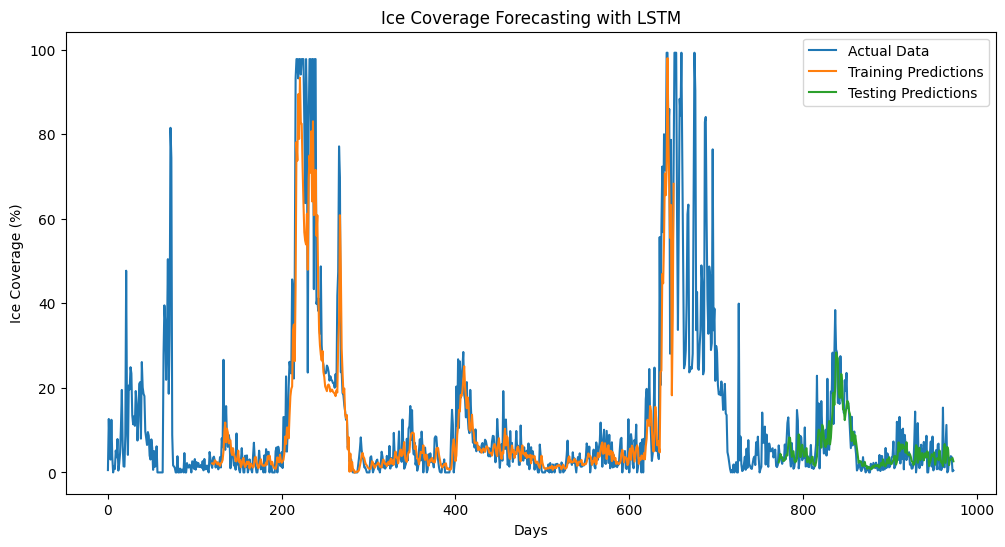

In [67]:
# Predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform the predictions to get them in the original scale
train_predict = (train_predict * (np.max(train_data) - np.min(train_data))) + np.min(train_data)
test_predict = (test_predict * (np.max(test_data) - np.min(test_data))) + np.min(test_data)
train_predict = (train_predict*85)
test_predict = (test_predict*85)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(coverage_data, label='Actual Data')
plt.plot(range(seq_length, train_size), train_predict, label='Training Predictions')
plt.plot(range(train_size + seq_length, len(coverage_data)), test_predict, label='Testing Predictions')
plt.legend()
plt.title('Ice Coverage Forecasting with LSTM')
plt.xlabel('Days')
plt.ylabel('Ice Coverage (%)')
plt.show()